# Resources

https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

https://github.com/vwxyzjn/cleanrl?tab=readme-ov-file

# Import

In [9]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Params

In [10]:
ENV_ARGS = {
    'id': "HalfCheetah-v4"
}
NUM_ENVS = 6
SEED = 1
LR = 1e-4
NUM_STEPS = 2048
NUM_ITERATIONS = 1000
GAMMA = 0.99
GAE_LAMBDA = 0.95
UPDATE_EPOCHS = 10
CLIP_COEF = 0.2 # the epsilon in KL divergece in PPO paper
ENTROPY_COEF = 0.0
VF_COEF = 0.5
MAX_GRAD_NORM = 0.5
MINI_BATCH_COUNT = 32
UPDATE_PLOTS = 10

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#output directory
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output', ENV_ARGS['id'])

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

#seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type(torch.FloatTensor)

# Make envs

In [11]:
def make_env(gamma, **env_args):
    env = gym.make(**env_args)
    env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = gym.wrappers.ClipAction(env)
    # env = gym.wrappers.NormalizeObservation(env)
    # env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
    env = gym.wrappers.NormalizeReward(env, gamma = gamma)
    env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
    return env


In [12]:
# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 

#check to make sure this is continous action
assert isinstance(envs.single_action_space, gym.spaces.Box), 'Only continous action is supported'

# Model

In [13]:
def layer_init(layer: nn.Linear, std = np.sqrt(2), bias_const = 0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):

    def __init__(self, envs: gym.Env, hidden_size: int = 64):

        super().__init__()
        self.state_shape = np.array(envs.single_observation_space.shape).prod()
        self.action_shape = np.prod(envs.single_action_space.shape)

        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(self.state_shape, hidden_size)),
            #NOTE: why use tanh here? 
            nn.Tanh(),
            layer_init(nn.Linear(hidden_size, hidden_size)),
            nn.Tanh(),
            # NOTE: what's the STD do in layer initialization???
            layer_init(layer = nn.Linear(hidden_size, self.action_shape), std = 0.01),
        )

        #shape = (1, state_shape)
        self.actor_logstd = nn.Parameter(torch.zeros(1, self.action_shape, dtype=torch.float))

        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.state_shape, hidden_size)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_size, hidden_size)),
            nn.Tanh(),
            # NOTE: what's the STD do in layer initialization???
            layer_init(nn.Linear(hidden_size, 1), std = 1.0),
        )
    
    def get_value(self, x):
        return self.critic(x)
    
    def get_action_and_value(self, x, action = None):
        '''
        @params:
            x: torch.tensor observation, shape = (N, observation size)
            action: torch.tensor action
        @returns:
            action: torch.tensor, shape = (N, action size)
            log_prob: torch.tensor, shape = (N,)
            entropy: torch.tensor, shape = (N,)
            value: torch.tensor, shape = (N,)
        '''
        action_mean = self.actor_mean(x)
        #make action logstd the shape[0] with mean
        action_logstd = self.actor_logstd.expand_as(action_mean)
        #exponential trick to remove log
        action_std = torch.exp(action_logstd)

        probs = torch.distributions.Normal(action_mean, action_std)

        if action is None:
            action = probs.sample() 
        
        #get value from critic
        value = self.get_value(x)
        log_prob = probs.log_prob(action).sum(1)
        #entropy for regularization
        entropy = probs.entropy().sum(1)
        
        return action, log_prob, entropy, value

In [14]:
#Test agent
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 
obs, info = envs.reset()

test_agent = Agent(envs)

obs = torch.tensor(obs).float()

action, log_prob, entropy, value = test_agent.get_action_and_value(obs)

print('state shape = ', obs.shape)
print('action shape = ', envs.single_action_space.shape)
print('log prob shape = ', log_prob.shape)
print('entropy shape = ', entropy.shape)
print('value shape = ', value.shape)

del test_agent

envs.close()

state shape =  torch.Size([6, 17])
action shape =  (6,)
log prob shape =  torch.Size([6])
entropy shape =  torch.Size([6])
value shape =  torch.Size([6, 1])


# Utils

In [15]:
def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

def pickle_dump(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)
    
def pickle_load(path):
    with open(path, 'rb') as file:
        obj = pickle.dump(file)
    return obj

def evaluate(agent, episodes = 10, human_render = False):
    if human_render:
        ENV_ARGS['render_mode'] = 'human'
    envs = gym.vector.SyncVectorEnv([lambda: make_env(gamma = GAMMA, **ENV_ARGS)])
    agent.eval()
    total_rewards = []
    next_obs, _ = envs.reset()

    while len(total_rewards) < episodes: 
        next_obs = torch.Tensor(next_obs)
        with torch.no_grad():
            action, log_prob, _, value = agent.get_action_and_value(next_obs)

        next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

        if 'final_info' in info:
            for data in info['final_info']:
                if data:
                    reward = data['episode']['r'][0]
                    total_rewards.append(reward)
    
    if human_render:
        del ENV_ARGS['render_mode']

    return total_rewards

In [16]:
# def evaluate(agent, episodes = 10):
#     envs = gym.vector.SyncVectorEnv([lambda: make_env(gamma = GAMMA, **ENV_ARGS)])
#     agent.eval()
#     total_rewards = []
#     next_obs, _ = envs.reset()

#     while len(total_rewards) < episodes: 
#         next_obs = torch.Tensor(next_obs)
#         with torch.no_grad():
#             action, log_prob, _, value = agent.get_action_and_value(next_obs)

#         next_obs, reward, terminated, truncated, info = envs.step(action.numpy())

#         if 'final_info' in info:
#             for data in info['final_info']:
#                 if data:
#                     reward = data['episode']['r'][0]
#                     total_rewards.append(reward)

#     return total_rewards

In [17]:
def tune(envs, agent, optimizer, num_steps, num_envs, device, 
         num_iterations = 1000, update_epochs = 10,
         label = 'baseline', plot_update_freq = 10, history = None):

    # label = str(uuid.uuid4()).split('-')[0]
    agent.to(device)

    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    HISTORY_SAVE_PATH = os.path.join(SAVE_PATH, 'history.pickle')

    if os.path.exists(SAVE_PATH) == False:
        print(f'output folder: {SAVE_PATH}')
        os.makedirs(SAVE_PATH)
    print('save path = ', SAVE_PATH)

    M,N = num_steps, num_envs

    obs = torch.zeros((M, N) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((M,N) + envs.single_action_space.shape).to(device)
    log_probs = torch.zeros((M,N)).to(device)
    rewards = torch.zeros((M,N)).to(device)
    dones = torch.zeros((M,N)).to(device) # for masking
    values = torch.zeros((M,N)).to(device)

    global_step = 0

    #Reset env
    next_obs, _ = envs.reset()
    next_obs = torch.tensor(next_obs).float().to(device)
    next_done = torch.zeros(N).to(device) #N is num envs

    print('next obs = ', next_obs.shape)
    print('next done = ', next_done.shape)

    reward_window = deque(maxlen = 100)

    if history == None:
        history = defaultdict(list)

    loop = tqdm(range(num_iterations))
    agent.train()

    best_score = -float('inf')
    loss = float('inf')

    for iter in loop:

        if iter % plot_update_freq == 0: 
            loop.set_description(f"avg_reward = {np.mean(reward_window):.2f}, best_score = {best_score}, episode_count = {len(history['reward'])}")
            plot(history, save_path = FIG_SAVE_PATH)
            pickle_dump(history, HISTORY_SAVE_PATH)

        #ROLLOUT phase
        #M is max steps
        for step in range(M):
            global_step += N

            obs[step] = next_obs
            dones[step] = next_done

            #get action
            #NOTE: no_grad disables gradient calculation --> reduce memory consumption
            #the result of every computation will have requires_grad=False
            with torch.no_grad():
                action, log_prob, _, value = agent.get_action_and_value(next_obs)
                values[step] = value.flatten()

            actions[step] = action
            log_probs[step] = log_prob

            #make next step with actions
            next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())

            next_done = np.logical_or(terminated, truncated)

            #NOTE: difference between view and reshape
            # https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch
            rewards[step] = torch.tensor(reward).view(-1)
            next_obs = torch.tensor(next_obs).float().to(device)
            next_done = torch.tensor(next_done).float().to(device)

            #NOTE: vector envs will automatically reset, so no need to break 
            if 'final_info' in info:
                for data in info['final_info']:
                    if data:
                        reward = data['episode']['r']
                        reward_window.append(reward)
                        avg_reward = np.mean(reward_window)
                        history['reward'].append(avg_reward)

                        if best_score < avg_reward:
                            best_score = avg_reward
                            #save model
                            torch.save(agent, os.path.join(SAVE_PATH, 'ppo.checkpoint.torch'))
            
        #update the history for plotting, and printing progress

        #OPTIMIZE phase:
        with torch.no_grad():
            #bootstrap values, compute returns
            next_value = agent.get_value(next_obs).reshape(1,-1)
            advantages = torch.zeros_like(rewards).to(device)
            last_gae_lambda = 0

            for t in reversed(range(NUM_STEPS)):
                if t == NUM_STEPS - 1:
                    next_none_terminal = np.logical_not(next_done.cpu())
                    next_values = next_value
                else:
                    next_none_terminal = np.logical_not(dones[t + 1].cpu())
                    next_values = values[t + 1]

                next_none_terminal = next_none_terminal.to(device)
                
                #A(s,a) = Q(s,a) - V(s,a) = r(t) + gamma * V(s', a) * mask - V(s)
                delta = rewards[t] + GAMMA * next_values * next_none_terminal - values[t]
                #NOTE: learn about this formula
                advantages[t] = last_gae_lambda = delta + GAMMA * GAE_LAMBDA * next_none_terminal * last_gae_lambda
            returns = advantages + values
        
        #flatten the batch
        b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
        b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
        b_log_probs = log_probs.reshape(-1)
        b_advantages = advantages.reshape(-1)
        b_returns = returns.reshape(-1)
        b_values = values.reshape(-1)

        #NOTE: randomize the batch to break correlation
        batch_size = M * N
        mini_batch_size = batch_size // MINI_BATCH_COUNT
        b_indicies = np.arange(batch_size)
        clip_fracs = []
        
        for _ in range(update_epochs):
            np.random.shuffle(b_indicies)

            #NOTE: mini-batch update: 
            # pros: reduce memory usage, faster updates
            # pros: a whole batch may stuck in local minima, mini batches introduce randomness
            # cons: estimate a true gradient, larger mini batch size --> more accurate but more memory
            for start in range(0, batch_size, mini_batch_size):
                end = start + mini_batch_size
                mini_indicies = b_indicies[start:end]

                _, new_log_prob, entropy, new_value = agent.get_action_and_value(b_obs[mini_indicies], b_actions[mini_indicies])

                #NOTE: what formula is this? 
                log_ratio = new_log_prob - b_log_probs[mini_indicies]

                ratio = log_ratio.exp() # trick to remove log

                #compute approximate KL: http://joschu.net/blog/kl-approx.html
                with torch.no_grad():
                    old_approx_kd = (-log_ratio).mean()
                    approximate_kl = ((ratio - 1) - log_ratio).mean()
                    clip_fracs += [((ratio - 1.0).abs() > CLIP_COEF).float().mean().item()]

                mb_advantages = b_advantages[mini_indicies]

                #normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                #policy loss (actor)

                pg_loss1 = -mb_advantages * ratio
                pg_loss2= -mb_advantages * torch.clamp(ratio, 1 - CLIP_COEF, 1 + CLIP_COEF)

                pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                new_value = new_value.view(-1)

                #value loss (MSE)
                v_loss = 0.5 * ((new_value - b_returns[mini_indicies]) ** 2).mean()

                entropy_loss = entropy.mean()

                loss = pg_loss - ENTROPY_COEF * entropy_loss + v_loss * VF_COEF

                optimizer.zero_grad()
                loss.backward()
                #clip grad
                nn.utils.clip_grad_norm_(agent.parameters(), MAX_GRAD_NORM)
                optimizer.step()

        
    torch.save(agent, os.path.join(SAVE_PATH, 'ppo.final.torch'))
    plot(history, show=True, save_path=FIG_SAVE_PATH)

    pickle_dump(history, HISTORY_SAVE_PATH)

    return history

save path =  /Volumes/SanDisk/NLP_RNN/Reinforcement Learning/deep rl/final_project/ppo/output/HalfCheetah-v4/baseline
next obs =  torch.Size([6, 17])
next done =  torch.Size([6])


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
avg_reward = 1545.04, best_score = 1572.541259765625, episode_count = 24510: 100%|██████████| 2000/2000 [1:35:04<00:00,  2.85s/it] 


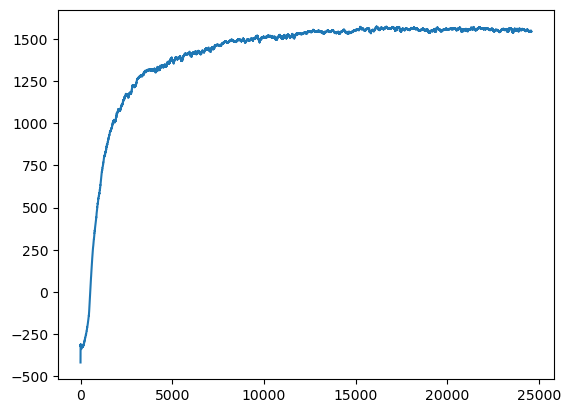

In [18]:
# Create env
envs = gym.vector.AsyncVectorEnv(
    [lambda : make_env(gamma= 0.99, **ENV_ARGS) for _ in range(NUM_ENVS)]
) 
#check to make sure this is continous action
assert isinstance(envs.single_action_space, gym.spaces.Box), 'Only continous action is supported'

agent = Agent(envs)
optimizer = torch.optim.Adam(agent.parameters(), lr = 1e-4, eps = 1e-5)

M = NUM_STEPS
N = NUM_ENVS
num_iterations = 2000

history = tune(envs, agent, optimizer, NUM_STEPS, NUM_ENVS, device=  DEVICE, num_iterations=num_iterations, label = 'baseline', plot_update_freq=5)


# Evaluation

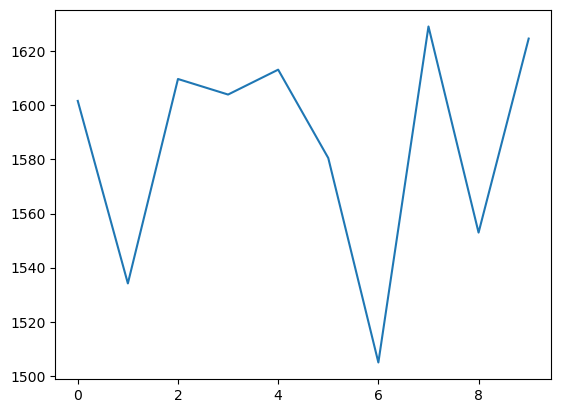

In [19]:
LOAD_MODEL_PATH = os.path.join(OUTPUT, 'baseline', 'ppo.checkpoint.torch')
agent = torch.load(LOAD_MODEL_PATH)

total_rewards = evaluate(agent)

sns.lineplot(y = total_rewards, x = list(range(len(total_rewards))))
EVALUATION_PLOT_SAVE = os.path.join(OUTPUT, 'baseline', 'evaluation.png') 
plt.savefig(EVALUATION_PLOT_SAVE)
plt.show()

In [20]:
total_rewards = evaluate(agent, episodes=1, human_render=True)

Exception ignored in: <function WindowViewer.__del__ at 0x301fcd040>
Traceback (most recent call last):
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/envs/mujoco/mujoco_rendering.py", line 335, in __del__
    self.free()
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/envs/mujoco/mujoco_rendering.py", line 330, in free
    glfw.destroy_window(self.window)
  File "/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/glfw/__init__.py", line 1279, in destroy_window
    window_addr = ctypes.cast(ctypes.pointer(window),
TypeError: _type_ must have storage info
